In [1]:
##before continuing the following packages need to be runned
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [65]:
portfolio_data <- read_csv("final_data.csv")|>
mutate(max_portfolio_return_name = as_factor(max_portfolio_return_name))|>
select(-year, -max_portfolio_return_value)
portfolio_data

Rows: 25 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): max_portfolio_return_name
dbl (5): year, annual_inflation, real_gdp_growth_rate_percentage, annual_une...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


annual_inflation,real_gdp_growth_rate_percentage,annual_unemployment_rate,max_portfolio_return_name
<dbl>,<dbl>,<dbl>,<fct>
2.337690,4.4,4.950000,60/40_portfolio_return_percentage
1.552279,4.5,4.508333,growth_portfolio_return_percentage
2.188027,4.8,4.216667,growth_portfolio_return_percentage
⋮,⋮,⋮,⋮
1.812210,2.3,3.666667,growth_portfolio_return_percentage
1.233584,-3.4,8.091666,growth_portfolio_return_percentage
4.697859,5.7,5.366667,growth_portfolio_return_percentage


In [66]:
set.seed(9999) #ensuring reproducibility
options(repr.plot.height = 5, repr.plot.width = 6)

portfolio_split <- initial_split(portfolio_data, prop = 0.75, strata = max_portfolio_return_name)
portfolio_train <- training(portfolio_split)
portfolio_test <- testing(portfolio_split) 

In [67]:
knn_recipe <- recipe(max_portfolio_return_name ~ annual_inflation + real_gdp_growth_rate_percentage + annual_unemployment_rate, data = portfolio_train) |>
    step_center(all_predictors()) |>
    step_scale (all_predictors())

In [68]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
set_engine("kknn") |>
set_mode("classification") 

! Fold1: preprocessor 1/1, model 1/1: 15 samples were requested but there were 13 rows in the data. 8 will be ...

! Fold1: preprocessor 1/1, model 1/1 (predictions): data length [60] is not a sub-multiple or multiple of the number of colu...

! Fold1: internal:
  No observations were detected in `truth` for level(s): '60/40_portfoli...
  Computation will proceed by ignoring those levels.

! Fold2: preprocessor 1/1, model 1/1: 15 samples were requested but there were 13 rows in the data. 8 will be ...

! Fold2: preprocessor 1/1, model 1/1 (predictions): data length [65] is not a sub-multiple or multiple of the number of colu...

! Fold2: internal:
  No observations were detected in `truth` for level(s): '40/60_portfoli...
  Computation will proceed by ignoring those levels., No observations we...
  Computation will proceed by ignoring those levels.

! Fold3: preprocessor 1/1, model 1/1: 15 samples were requested but there were 14 rows in the data. 9 will be ...

! Fold3: preprocessor 1

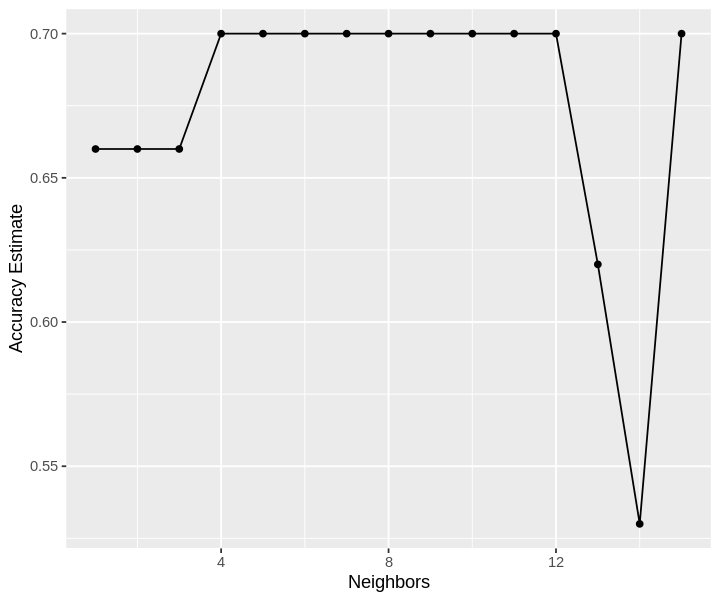

In [69]:
set.seed(9999) #ensuring reproducibility

knn_vfold <- vfold_cv(portfolio_train, v = 5, strata = max_portfolio_return_name)
gridvals <- tibble(neighbors = seq(from = 1, to = 15))

knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_tune) |>
  tune_grid(resamples = knn_vfold, grid = gridvals) |>
  collect_metrics() 

accuracies <- knn_results |> 
       filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot                                                                     

In [70]:
# based on the plot,  we will pick K=8 because it the median neighbor between the equal-accuracy-range of K=4-12. choosing k=8 ensures that going a bit to the righ or left leaves the accuracy estimate intact
# We certainly believe that in order to enhance our model, more data should be collected for each variable. Unfortunatly, our data was restricted for data from 1997-2021. 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
set_engine("kknn") |>
set_mode("classification")

knn_fit <- workflow() |>
add_recipe(knn_recipe) |>
add_model(knn_spec) |>
fit(data = portfolio_train)

In [71]:
#testing model predictions with testing set

set.seed(9999) #ensuring reproducibility

test_predictions <- predict(knn_fit,portfolio_test) |>
bind_cols(portfolio_test)

knn_metrics <- test_predictions |>
metrics(truth = max_portfolio_return_name, estimate = .pred_class)
knn_metrics

#accuracy seems to improve a bit (from 70% up to ~71%) when applying model to testing dataset

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7142857
kap,multiclass,0.3913043


In [94]:
#This is the new observation to predict

new_economic_environment_1 <- tibble(annual_inflation = 1, real_gdp_growth_rate_percentage = 2.3, annual_unemployment_rate = 4)

portfolio_prediction <- predict(knn_fit, new_economic_environment_1)
portfolio_prediction

new_economic_environment_2 <- tibble(annual_inflation = 8, real_gdp_growth_rate_percentage = 2, annual_unemployment_rate = 4)

portfolio_prediction <- predict(knn_fit, new_economic_environment_2)
portfolio_prediction
    
    

.pred_class
<fct>
60/40_portfolio_return_percentage


.pred_class
<fct>
growth_portfolio_return_percentage


In [95]:
#Before being done, checking proper balancing of classes is needed!